# **Introduction to the Cart Pole Problem**

# Table of Contents




- [Introduction to the Cart Pole Problem](#introduction-to-the-cart-pole-problem)
- [Setup](#Setup)
- [DQN](#dqn)
  - [Implementing DQN components](#implementing-dqn-components)
    - [Replay Memory Class](#replay-memory-class)
    - [DQN Network Class](#dqn-network-class)
    - [DQN Agent Class](#dqn-agent-class)
  - [Model_TrainTest Class](#model-traintest-class)
    - [State Preprocessing](#state-preprocessing)
    - [Training](#training)
    - [Testing](#testing)
    - [Visualization](#visualization)

## **Overview**


This project focuses on applying and comparing two popular reinforcement learning algorithms, Deep Q-Network (DQN) and State-Action-Reward-State-Action (SARSA), to solve the classic "Cart Pole" problem. This problem is a fundamental test in the field of reinforcement learning, where the objective is to balance a pole, hinged to a cart, by moving the cart left or right.

### Objectives

The main goals of this project are to:


*   implement the DQN and SARSA algorithms using PyTorch.
*   train these models to balance the pole on the moving cart as long as possible.
*   evaluate and compare the performance of these algorithms in terms of learning efficiency and stability.

#**Setup**

### **Running the Notebook**

This notebook is designed to run in Google Colab. It requires no additional setup from the user's local environment except access to the internet and a Google account.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installation of Required Libraries

Before we start implementing the algorithms, we need to ensure that all necessary libraries are installed. Run the following cells to install the required packages.

In [7]:
!pip install gymnasium
!pip install torch
!pip install renderlab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

### Importing Libraries

Now, let's import the necessary libraries that we will use throughout this project.

In [8]:
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
import renderlab
import pygame
import matplotlib.image as mpimg


### Setting Up GPU and Reproducibility

This section initializes the environment and sets up the GPU (if available) for computation. It also ensures reproducibility by setting random seeds.

In [9]:
print(f"torch.cuda: {torch.cuda.is_available()}" )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.cuda: False
Using device: cpu


In [10]:
# Clear memory and set random seeds for reproducibility
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Immediate CUDA error reporting
seed = 2024
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# **SARSA**

## SARSA Algorithm Overview

SARSA is an on-policy reinforcement learning algorithm that updates the action-value function based on the state-action pairs and the reward observed, followed by the next state-action pairs. It is commonly used to solve Markov decision processes.

### 1. SARSA Agent Class


### 2. Training Loop Integration

You will integrate the SARSA agent into your training loop, where the agent will decide actions, observe outcomes, and learn from them.

Here's how you might integrate the SARSA agent into the training loop:

In [11]:
class Memory:
    def __init__(self, capacity):
        # Initialize replay memory with a specified capacity
        self.capacity = capacity
        self.states = deque(maxlen=capacity)
        self.actions = deque(maxlen=capacity)
        self.next_states = deque(maxlen=capacity)
        self.next_actions = deque(maxlen=capacity)
        self.rewards = deque(maxlen=capacity)
        self.dones = deque(maxlen=capacity)

    def store(self, state, action, next_state, next_action, reward, done):
        # Store an experience (state, action, next_state, reward, done) in the replay memory
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.next_actions.append(next_action)
        self.rewards.append(reward)
        self.dones.append(done)

    def get_all(self):
        # Get all the contents of memory
        states = torch.stack([torch.as_tensor(state, dtype=torch.float32, device=device) for state in self.states])
        actions = torch.as_tensor(self.actions, dtype=torch.long, device=device)
        next_states = torch.stack([torch.as_tensor(next_state, dtype=torch.float32, device=device) for next_state in self.next_states])
        next_actions = torch.stack([torch.as_tensor(next_action, dtype=torch.long, device=device) for next_action in self.next_actions])
        rewards = torch.as_tensor(self.rewards, dtype=torch.float32, device=device)
        dones = torch.as_tensor(self.dones, dtype=torch.bool, device=device)
        return states, actions, next_states, next_actions, rewards, dones

    def __len__(self):
        # Return the current size of the memory
        return len(self.dones)

    def clear(self):
        # Clear all the deque objects
        self.states.clear()
        self.actions.clear()
        self.next_states.clear()
        self.next_actions.clear()
        self.rewards.clear()
        self.dones.clear()

In [12]:
class SARSA_Network(nn.Module):

    def __init__(self, num_actions, input_dim):
        super(SARSA_Network, self).__init__()

        # Define the neural network layers
        self.FC = nn.Sequential(
            nn.Linear(input_dim, 512),  # Input layer to first hidden layer with 512 nodes
            nn.ReLU(),                 # ReLU activation for non-linearity
            nn.Linear(512, 256),       # Second hidden layer with 256 nodes
            nn.ReLU(),                 # ReLU activation for non-linearity
            nn.Linear(256, 64),        # Third hidden layer with 64 nodes
            nn.ReLU(),                 # ReLU activation for non-linearity
            nn.Linear(64, num_actions) # Output layer with 'num_actions' nodes
        )
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.FC(x)

In [13]:
class SARSA_Agent:

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay,
                 clip_grad_norm, learning_rate, discount, memory_capacity):

        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

        # RL hyperparameters
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount = discount

        self.state_size = env.observation_space.shape[0]
        self.action_space = env.action_space
        self.action_space.seed(seed)  # Set the seed to get reproducible results when sampling the action space
        self.observation_space = env.observation_space
        self.memory = Memory(memory_capacity)

        # Initiate the network models
        self.main_network = SARSA_Network(input_dim=(self.state_size), num_actions=self.action_space.n).to(device)
        self.target_network = SARSA_Network(input_dim=(self.state_size), num_actions=self.action_space.n).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = clip_grad_norm  # For clipping exploding gradients caused by high reward value
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)

    def select_action(self, state):

        # Exploration: epsilon-greedy
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # # Exploitation: the action is selected based on the Q-values.
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()
            return action

    def learn(self, done):

        if self.memory.__len__() > self.memory.capacity:
            return

        states, actions, next_states, next_actions, rewards, dones = self.memory.get_all()
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        next_actions = next_actions.unsqueeze(1)

        predicted_q = self.main_network(states)
        predicted_q = predicted_q.gather(dim=1,index=actions)

        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            next_target_q_value = next_q_values.gather(dim=1, index=next_actions)

        next_target_q_value[dones] = 0  # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value)  # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js)  # Compute the loss

        # Update the running loss and learned counts for logging and plotting
        self.running_loss += loss.item()
        self.learned_counts += 1

        if done:
            episode_loss = self.running_loss / self.learned_counts  # The average loss for the episode
            self.loss_history.append(episode_loss)  # Append the episode loss to the loss history for plotting
            # Reset the running loss and learned counts
            self.running_loss = 0
            self.learned_counts = 0

        self.optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Perform backward pass and update the gradients

        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()  # Update the parameters of the main network using the optimizer

    def hard_update(self):
        self.target_network.load_state_dict(self.main_network.state_dict())

    def update_epsilon(self):
        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)

    def save(self, path):

        torch.save(self.main_network.state_dict(), path)


In [14]:
class Model_TrainTest:
    def __init__(self, hyperparams):

        # Define RL Hyperparameters
        self.train_mode = hyperparams["train_mode"]
        self.RL_load_path = hyperparams["RL_load_path"]
        self.save_path = hyperparams["save_path"]
        self.save_interval = hyperparams["save_interval"]
        self.report = hyperparams["report"]
        self.early_stop_threshold = hyperparams["early_stop_threshold"]
        self.early_stop_window = hyperparams["early_stop_window"]
        self.render_output_path = hyperparams["render_output_path"]

        self.clip_grad_norm = hyperparams["clip_grad_norm"]
        self.learning_rate = hyperparams["learning_rate"]
        self.discount_factor = hyperparams["discount_factor"]

        self.update_frequency = hyperparams["update_frequency"]
        self.max_episodes = hyperparams["max_episodes"]
        self.max_steps = hyperparams["max_steps"]
        self.render = hyperparams["render"]

        self.epsilon_max = hyperparams["epsilon_max"]
        self.epsilon_min = hyperparams["epsilon_min"]
        self.epsilon_decay = hyperparams["epsilon_decay"]

        self.memory_capacity = hyperparams["memory_capacity"]

        self.num_states = hyperparams["num_states"]
        self.map_size = hyperparams["map_size"]
        self.render_fps = hyperparams["render_fps"]

        # Define Env
        self.env = gym.make('CartPole-v1',
                            render_mode="rgb_array" if self.render else None)
        self.env.metadata['render_fps'] = self.render_fps  # For max frame rate make it 0
        # Define the agent class
        self.agent = SARSA_Agent(env=self.env,
                               epsilon_max=self.epsilon_max,
                               epsilon_min=self.epsilon_min,
                               epsilon_decay=self.epsilon_decay,
                               clip_grad_norm=self.clip_grad_norm,
                               learning_rate=self.learning_rate,
                               discount=self.discount_factor,
                               memory_capacity=self.memory_capacity)


    def state_preprocess(self, state: int, num_states: int):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        return state

    def train(self):

        total_steps = 0
        self.reward_history = []
        self.epsilon_history = []
        consecutive_rewards = 0

        # Training loop over episodes
        for episode in range(1, self.max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
            action = self.agent.select_action(state)
            while not done and not truncation:
                next_state, reward, done, truncation, _ = self.env.step(action)

                next_state = self.state_preprocess(next_state, num_states=self.num_states)
                next_action = self.agent.select_action(next_state)

                angle = next_state[2]  # Assuming next_state[2] is the pole angle
                angle_reward = 1.0 - abs(angle) / np.pi  # Normalize and invert the angle to get reward
                reward += angle_reward  # Modify reward with additional reward shaping
                x_pos = abs(next_state[0])
                if x_pos > 4:
                    reward -= x_pos
                elif x_pos > 2:
                    reward -= x_pos * 0.5
                if (reward > 0):
                        reward /= 2
                self.agent.memory.store(state, action, next_state, next_action, reward, done)

                if self.agent.memory.__len__() >= self.memory_capacity and sum(self.reward_history) > 0:
                    self.agent.learn((done or truncation))

                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.agent.hard_update()

                    self.agent.memory.clear()

                state = next_state
                action = next_action
                episode_reward += reward
                step_size += 1

            # Appends for tracking history
            self.reward_history.append(episode_reward)  # episode reward
            self.epsilon_history.append(self.agent.epsilon_max)
            total_steps += step_size

            if episode_reward >= self.early_stop_threshold:
                consecutive_rewards += 1
            else:
                consecutive_rewards = 0

             # Check for early stopping condition
            if consecutive_rewards >= self.early_stop_window:
                result = (f"Episode: {episode}, "
                          f"Total Steps: {total_steps}, "
                          f"Ep Step: {step_size}, "
                          f"Raw Reward: {episode_reward:.2f}, "
                          f"Epsilon: {self.agent.epsilon_max:.2f}")
                print(result)
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                print(f"Early stopping at episode {episode} as reward exceeded threshold for {self.early_stop_window} consecutive episodes.")

                break
            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()

            # -- based on interval
            if episode % self.save_interval == 0 or episode == self.max_episodes or episode == 10:
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                # if episode != self.max_episodes:
                    # self.plot_training(episode)
                print('\n~~~~~~Interval Save: Model saved.\n')

            if episode % self.report == 0:
                result = (f"Episode: {episode}, "
                          f"Total Steps: {total_steps}, "
                          f"Ep Step: {step_size}, "
                          f"Raw Reward: {episode_reward:.2f}, "
                          f"Epsilon: {self.agent.epsilon_max:.2f}")
                print(result)
        self.plot_training(episode)

    def test(self, max_episodes):
        """
        Reinforcement learning policy evaluation.
        """
        env = renderlab.RenderFrame(self.env, self.render_output_path)
        # Load the weights of the test_network
        self.agent.main_network.load_state_dict(torch.load(self.RL_load_path, map_location=torch.device('cpu')))
        self.agent.main_network.eval()

        # Testing loop over episodes
        for episode in range(1, max_episodes + 1):
            state, _ = env.reset(seed=seed)
            # state, _ = self.env.reset(seed=seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                state = self.state_preprocess(state, num_states=self.num_states)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = env.step(action)
                # next_state, reward, done, truncation, _ = self.env.step(action)

                state = next_state
                episode_reward += reward
                step_size += 1

            # Print log
            result = (f"total Steps: {step_size:}, "
                      f"Reward: {episode_reward:.2f}, ")
            print(result)


        env.play()
        pygame.quit()  # close the rendering window

    def plot_training(self, episode):
        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50) / 50, mode='valid')

        # Plot Rewards
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./reward_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

        # Plot Loss
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./Loss_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

        # Plot Epsilon Decay (ε-greedy)
        plt.figure()
        plt.title("Epsilon Decay (ε-greedy)")
        plt.plot(np.arange(1, episode + 1), self.epsilon_history, color='g')
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./Epsilon_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

In [15]:
def handler(train_mode=True, RL_hyperparameters = {}):
    # Initialize and run the model
    DRL = Model_TrainTest(RL_hyperparameters)
    if train_mode:
        DRL.train()
    else:
        DRL.test(max_episodes=RL_hyperparameters['max_episodes'])

In [16]:
def set_hyperparameters(train_mode):
    render = not train_mode
    RL_hyperparams = {
        "train_mode": train_mode,
        "RL_load_path": f'./final_weights_{"30000"}.pth',
        "save_path": f'./final_weights',
        "render_output_path": "./output",
        "early_stop_threshold": 496,
        "early_stop_window": 30,
        "save_interval": 15000,
        "report": 250,
        "clip_grad_norm": 3,
        "learning_rate": 6e-4,
        "discount_factor": 0.8,
        "update_frequency": 1,
        "max_episodes": 30000 if train_mode else 1,
        "max_steps": 200,
        "render": render,
        "epsilon_max": 0.999 if train_mode else -1,
        "epsilon_min": 0.001,
        "epsilon_decay": 0.9998,
        "memory_capacity": 32 if train_mode else 0,
        "map_size": 16,
        "num_states": 8 ** 2,
        "render_fps": 30,
    }
    return RL_hyperparams


In [18]:
cd drive/MyDrive/DRL/cartpole/sarsa

/content/drive/MyDrive/DRL/cartpole/sarsa


In [20]:
############do not run #################

In [ ]:
RL_hyperparameters = set_hyperparameters(train_mode=True)
handler(train_mode=True, RL_hyperparameters=RL_hyperparameters)  # For training


~~~~~~Interval Save: Model saved.

Episode: 250, Total Steps: 5908, Ep Step: 16, Raw Reward: 15.84, Epsilon: 0.95
Episode: 500, Total Steps: 11764, Ep Step: 15, Raw Reward: 14.78, Epsilon: 0.90
Episode: 750, Total Steps: 18500, Ep Step: 46, Raw Reward: 45.37, Epsilon: 0.86
Episode: 1000, Total Steps: 26040, Ep Step: 14, Raw Reward: 13.79, Epsilon: 0.82
Episode: 1250, Total Steps: 34208, Ep Step: 39, Raw Reward: 38.63, Epsilon: 0.78
Episode: 1500, Total Steps: 44447, Ep Step: 20, Raw Reward: 19.83, Epsilon: 0.74
Episode: 1750, Total Steps: 54999, Ep Step: 29, Raw Reward: 28.79, Epsilon: 0.70
Episode: 2000, Total Steps: 66520, Ep Step: 22, Raw Reward: 21.56, Epsilon: 0.67
Episode: 2250, Total Steps: 80515, Ep Step: 133, Raw Reward: 131.56, Epsilon: 0.64
Episode: 2500, Total Steps: 95941, Ep Step: 24, Raw Reward: 23.78, Epsilon: 0.61
Episode: 2750, Total Steps: 113356, Ep Step: 194, Raw Reward: 192.51, Epsilon: 0.58
Episode: 3000, Total Steps: 132570, Ep Step: 125, Raw Reward: 123.61, Ep

In [ ]:
ls

Epsilon_plot.png      final_weights_15000.pth  Loss_plot.png
final_weights_10.pth  final_weights_30000.pth  reward_plot.png


### **visualizing**

In [21]:
def load_and_display_figures(main_title, epsilon_path, loss_path, reward_path):
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Load and display Epsilon plot
    epsilon_img = mpimg.imread(epsilon_path)
    axs[0].imshow(epsilon_img)
    axs[0].axis('off')
    axs[0].set_title('Epsilon Plot')

    # Load and display Loss plot
    loss_img = mpimg.imread(loss_path)
    axs[1].imshow(loss_img)
    axs[1].axis('off')
    axs[1].set_title('Loss Plot')

    # Load and display Reward plot
    reward_img = mpimg.imread(reward_path)
    axs[2].imshow(reward_img)
    axs[2].axis('off')
    axs[2].set_title('Reward Plot')

    # Add main title
    fig.suptitle(main_title, fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()

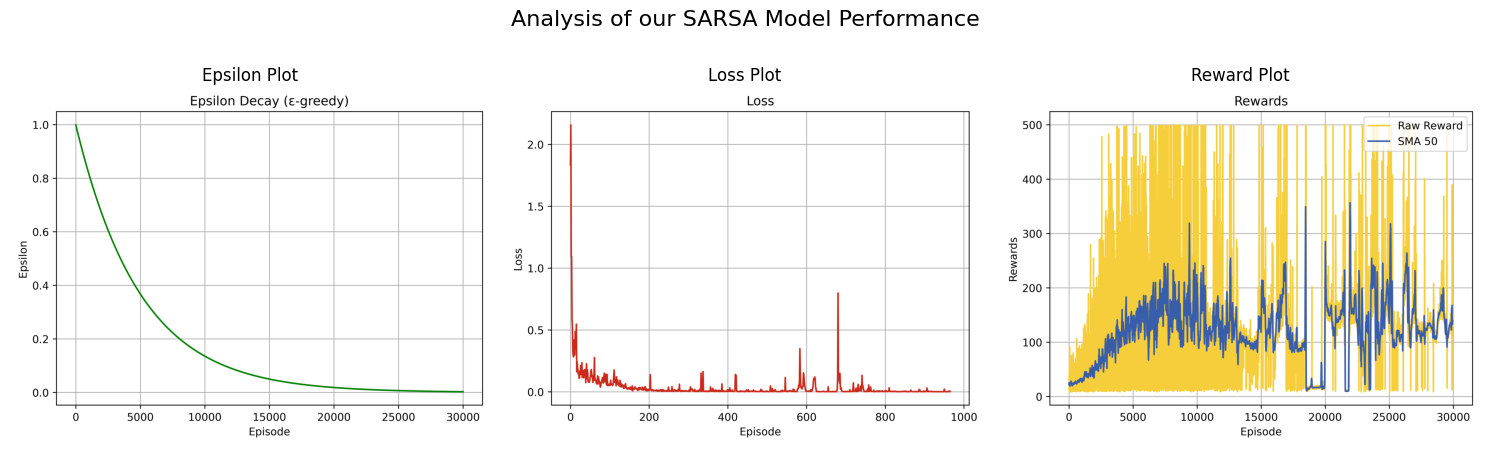

In [22]:
# Example usage
main_title = "Analysis of our SARSA Model Performance"
epsilon_path = "Epsilon_plot.png"
loss_path = "Loss_plot.png"
reward_path = "reward_plot.png"

load_and_display_figures(main_title, epsilon_path, loss_path, reward_path)

In [23]:
print("Testing the SARSA agent: ")
RL_hyperparameters = set_hyperparameters(train_mode=False)
handler(train_mode=False, RL_hyperparameters=RL_hyperparameters)


Testing the SARSA agent: 
total Steps: 145, Reward: 145.00, 
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  88%|████████▊ | 130/147 [00:00<00:00, 202.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1716454321.1768703.mp4, 720000 bytes wanted but 0 bytes read,at frame 146/147, at time 4.87/4.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
